<h3>Import module yang dibutuhkan</h3>

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator

<h3>Load the dataset<h3>


In [3]:

# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((30, 30))

# Number of images used to train the model
N_IMAGES = 500

# Path Cwd
cwd_dir = os.getcwd()

# Path to the dataset folder
root_dir = cwd_dir+'/Dataset'

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

<h3>Image Processing<h3>

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return np.array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = os.listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = os.listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing background ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Pepper,_bell___Bacterial_spot 

In [5]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  39


<h3>Augment Data<h3>

In [116]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

<h3>Converting lists into numpy arrays -> Dont Use<h3>

In [ ]:
data = np.array(np_image_list)
labels = np.array(image_labels)
print(labels.shape)

<h3>Save Labels & Data<h3>

In [6]:
np.save('./training/data',np_image_list)
np.save('./training/target',image_labels)

<h3>Load data & Labels<h3>

In [ ]:
np_image_list=np.load('./training/data.npy')
image_labels=np.load('./training/target.npy')

<h3>Split Dataset<h3>

In [7]:
X_train, X_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14266, 30, 30, 3) (3567, 30, 30, 3) (14266, 39) (3567, 39)


<h3>Build CNN Architecture</h3>

In [8]:
WIDTH = 30
HEIGHT = 30
DEPTH = 3
inputShape = (HEIGHT, WIDTH, DEPTH)

model = Sequential()
# Extracted Feature Layer
model.add(InputLayer(input_shape=inputShape))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
# Fully Connected Layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(39, activation='softmax'))






In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 64)        36928     
                                                        

In [10]:
# tentukan hyperparameter
lr = 0.001
max_epochs = 20 #100
opt_funct = Adam(learning_rate=lr)

In [11]:
#Compilation of the model
model.compile(loss='binary_crossentropy', optimizer=opt_funct, metrics=['accuracy'])

<h3>Train Model<h3>

In [12]:

history = model.fit(X_train, y_train, batch_size=32, epochs=max_epochs, validation_data=(X_test, y_test))
#history = model.fit_generator(augment.flow(X_train, y_train, batch_size=32),validation_data=(X_test, y_test),steps_per_epoch=len(X_train) // 32,epochs=max_epochs, verbose=1)

Epoch 1/20
446/446 [==============================] - 51s 113ms/step - loss: 0.1145 - accuracy: 0.1492 - val_loss: 0.0678 - val_accuracy: 0.4822
Epoch 2/20
446/446 [==============================] - 52s 118ms/step - loss: 0.0638 - accuracy: 0.5180 - val_loss: 0.0450 - val_accuracy: 0.6728
Epoch 3/20
446/446 [==============================] - 53s 120ms/step - loss: 0.0475 - accuracy: 0.6623 - val_loss: 0.0329 - val_accuracy: 0.7796
Epoch 4/20
446/446 [==============================] - 53s 119ms/step - loss: 0.0387 - accuracy: 0.7331 - val_loss: 0.0333 - val_accuracy: 0.7788
Epoch 5/20
446/446 [==============================] - 53s 119ms/step - loss: 0.0323 - accuracy: 0.7862 - val_loss: 0.0243 - val_accuracy: 0.8408
Epoch 6/20
446/446 [==============================] - 54s 121ms/step - loss: 0.0287 - accuracy: 0.8106 - val_loss: 0.0241 - val_accuracy: 0.8452
Epoch 7/20
446/446 [==============================] - 53s 120ms/step - loss: 0.0255 - accuracy: 0.8358 - val_loss: 0.0226 - val_ac

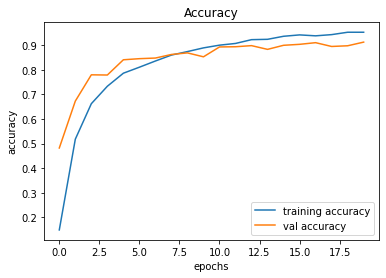

In [13]:
# Test Accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

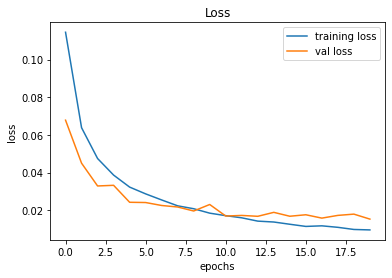

In [14]:
# Test Loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

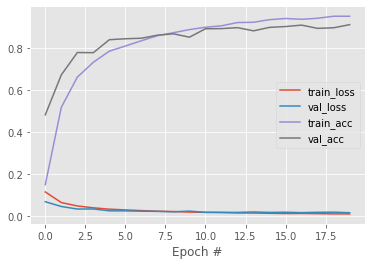

In [15]:
N = np.arange(0, max_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch #")
plt.legend()
plt.show()

<h3>Evaluate the Model</h3>

In [1]:
# menghitung nilai akurasi model terhadap data test
predictions = model.predict(X_test, batch_size=32)
#target = (predictions > 0.5).astype(np.int)
target = np.argmax(model.predict(predictions), axis=-1)
print(classification_report(y_test, target, target_names=label_list))

NameError: name 'model' is not defined

In [16]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
112/112 [==============================] - 3s 25ms/step - loss: 0.0154 - accuracy: 0.9125
Test Accuracy: 91.25315546989441


<h3>Test Model Accuracy Using Test Data</h3>

In [7]:
# Load model
filename = 'plant_disease_classification_model.h5'
model = load_model(filename)

# Load labels
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

In [10]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    #result = model.predict_classes(np_image)
    
    predict_x=model.predict(np_image) 
    classes_x=np.argmax(predict_x,axis=1)

    print((image_labels.classes_[classes_x][0]))


Blueberry___healthy


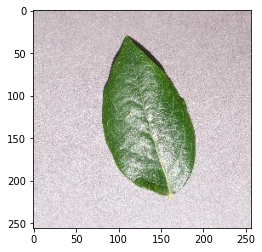

In [11]:
predict_disease('Dataset/val/Blueberry___healthy/008c85d0-a954-4127-bd26-861dc8a1e6ff___RS_HL 2431.JPG')

In [ ]:
predict_disease('Dataset/val/Blueberry___healthy/008c85d0-a954-4127-bd26-861dc8a1e6ff___RS_HL 2431.JPG')

<h3>Save Model</h3>

In [17]:
model.save('plant_disease_classification_model.h5')